<a href="https://www.kaggle.com/code/jy2040/ise244-learning-from-text?scriptVersionId=95321087" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [88]:
# libraries used for this task
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import numpy as np
from nltk.corpus import stopwords
import string
import collections
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_curve,roc_auc_score,precision_recall_curve
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt

In [89]:
# Load training data
POS_TRAIN_PATH = "../input/ise244-learge-movie-dataset/aclImdb/train/pos"
NEG_TRAIN_PATH = "../input/ise244-learge-movie-dataset/aclImdb/train/neg"
pos_data = []
neg_data = []
for item in os.listdir(POS_TRAIN_PATH):
    with open(POS_TRAIN_PATH + "/" + item, "r") as f:
        pos_data.append(f.read())

for item in os.listdir(NEG_TRAIN_PATH):
    with open(NEG_TRAIN_PATH + "/" + item, "r") as f:
        neg_data.append(f.read())
train_data = {
    "review": pos_data + neg_data,
    "label": [0] * len(pos_data) + [1] * len(neg_data)
}
train_data = pd.DataFrame(train_data)

In [90]:
# Load test data
POS_TEST_PATH = "../input/ise244-learge-movie-dataset/aclImdb/test/pos"
NEG_TEST_PATH = "../input/ise244-learge-movie-dataset/aclImdb/test/neg"
pos_data = []
neg_data = []
for item in os.listdir(POS_TEST_PATH):
    with open(POS_TEST_PATH + "/" + item, "r") as f:
        pos_data.append(f.read())

for item in os.listdir(NEG_TEST_PATH):
    with open(NEG_TEST_PATH + "/" + item, "r") as f:
        neg_data.append(f.read())
test_data = {
    "review": pos_data + neg_data,
    "label": [0] * len(pos_data) + [1] * len(neg_data)
}
test_data = pd.DataFrame(test_data)

In [91]:
def df_exploration(df, dataset_type):
    print('-'*50)
    print('\nHead of the {0} dataset\n {1}'.format(dataset_type,df.head()))
    print('\nTail of the {0} dataset\n {1}'.format(dataset_type,df.tail()))
    print('-'*50)

In [92]:
df_exploration(train_data, 'training')
df_exploration(train_data, 'test')

--------------------------------------------------

Head of the training dataset
                                               review  label
0  This was one of those wonderful rare moments i...      0
1  Have you seen The Graduate? It was hailed as t...      0
2  I don't watch a lot of TV, except for The Offi...      0
3  Kubrick again puts on display his stunning abi...      0
4  First of all, I liked very much the central id...      0

Tail of the training dataset
                                                   review  label
24995  The first hour of the movie was boring as hell...      1
24996  A fun concept, but poorly executed. Except for...      1
24997  I honestly don't understand how tripe like thi...      1
24998  This remake of the 1962 orginal film'o the boo...      1
24999  La Sanguisuga Conduce la Danza, or The Bloodsu...      1
--------------------------------------------------
--------------------------------------------------

Head of the test dataset
               

In [93]:
'''
For now, adding all data in one data frame for preprocess
'''
data = pd.concat([train_data, test_data])

In [94]:
df_exploration(data,'whole')

--------------------------------------------------

Head of the whole dataset
                                               review  label
0  This was one of those wonderful rare moments i...      0
1  Have you seen The Graduate? It was hailed as t...      0
2  I don't watch a lot of TV, except for The Offi...      0
3  Kubrick again puts on display his stunning abi...      0
4  First of all, I liked very much the central id...      0

Tail of the whole dataset
                                                   review  label
24995  This is one of those inoffensive and mildly en...      1
24996  When people say children are annoying u think ...      1
24997  OK, I don't want to upset anyone who enjoyed t...      1
24998  Words can scarcely describe this movie. Loaded...      1
24999  I watched this movie last night, i'm a huge fa...      1
--------------------------------------------------


In [95]:
%%time
'''
Performing required preprocessing on the dataset (removing stop words, vectorization etc.)
First I am creating the vocab file to clean the data on the latter part of the task
'''
# functions to clean the data and make a vocabulary file
# creating a vocabulary file to clean the data for following steps...
def clean_review(text):
    # split into tokens by white space
    text = text.lower()
    tokens = text.split()
    
    # remove punctuation from each token
    mapping_table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(mapping_table) for w in tokens]
    
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    
    # removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    
    # removing tokens with 1 length
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

# building a vocabulary out of all text documents
def create_vocab(data_review):
    vocabulary = collections.Counter()
    for doc in data_review:
        tokens = clean_review(doc)
        vocabulary.update(tokens)
    return vocabulary

vocab_dict = create_vocab(data.review)

# removing vocabulary which occures very less
min_occurrence = 2  #define your own occurrence count
tokens = [k for k,c in vocab_dict.items() if c >= min_occurrence]

CPU times: user 17.9 s, sys: 809 ms, total: 18.7 s
Wall time: 18.7 s


In [96]:
def save_list(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
    
# creating text file for vocabulary
save_list(tokens, 'vocab.txt')

In [97]:
# load doc into memory
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

vocab_filename = './vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

In [98]:
print("Total size of vocabulary from the reviews is",len(vocab),"words")

Total size of vocabulary from the reviews is 79750 words


In [99]:
# using vocabulary that we created in previous steps
def process_text(text, vocab):
    
    # split into tokens by white space
    tokens = text.split()
    
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # filter out tokens not in vocab
    
    tokens = [w for w in tokens if w in vocab]
    tokens = ' '.join(tokens)
    return tokens

def process_reviews(data_review, vocab):
    documents = list()
    for doc in data_review:
        tokens = process_text(doc, vocab)
        # add to list
        documents.append(tokens)
    return documents

In [100]:
%%time
processed_data = process_reviews(data.review, vocab)

CPU times: user 7.82 s, sys: 531 µs, total: 7.82 s
Wall time: 7.84 s


In [101]:
# text review after processing + cleaning it
processed_data[0]

'one wonderful rare moments wished captured forever ever air br br creative remember aired week wait next episode excruciating want see want buy want cant even br br ranted enough far one best series put considered classic lost space least website mention br utterly appealing funny flirtatious original like original actually think far attractive better chance leading lady stiff ever could'

### Building the model

### Creating a bag of words

In [102]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(norm = 'l2',min_df = 0, use_idf = True, smooth_idf = False, ngram_range=(1,2),
                             max_features = 7000, sublinear_tf = True )
X = vectorizer.fit_transform(processed_data)

CPU times: user 22.8 s, sys: 591 ms, total: 23.4 s
Wall time: 23.4 s


In [103]:
y = data.label.values

In [104]:
'''
Splitting the data into 80:20 ratio for evaluation purpose
'''
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.2)

### Models and Evaluation

In [105]:
 def model_evaluation(model, train_labels, test_labels, train_d, test_d):
    print("Accuracy on Train data:", accuracy_score(train_labels, model.predict(train_d)))
    print("Accuracy on Test data: ", accuracy_score(test_labels, model.predict(test_d)))
    print("Classification Report ...\n",classification_report(test_labels, model.predict(test_d)))
    print("Confusion matrix ...\n",confusion_matrix(test_labels, model.predict(test_d)))

In [106]:
%%time
# supervised
from sklearn.svm import LinearSVC
model_svc = LinearSVC(penalty='l2')
model_svc.fit(X_train, y_train)

CPU times: user 528 ms, sys: 25.9 ms, total: 554 ms
Wall time: 554 ms


LinearSVC()

In [107]:
model_evaluation(model_svc, y_train, y_test, X_train, X_test)

Accuracy on Train data: 0.940775
Accuracy on Test data:  0.8829
Classification Report ...
               precision    recall  f1-score   support

           0       0.88      0.89      0.88      5055
           1       0.88      0.88      0.88      4945

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Confusion matrix ...
 [[4481  574]
 [ 597 4348]]


In [108]:
%%time
# unsupervised
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0, init="k-means++").fit(X_train,y_train)

CPU times: user 8.25 s, sys: 13.5 ms, total: 8.26 s
Wall time: 4.39 s


In [109]:
model_evaluation(kmeans, y_train, y_test, X_train, X_test)

Accuracy on Train data: 0.652975
Accuracy on Test data:  0.6486
Classification Report ...
               precision    recall  f1-score   support

           0       0.64      0.72      0.67      5055
           1       0.67      0.58      0.62      4945

    accuracy                           0.65     10000
   macro avg       0.65      0.65      0.65     10000
weighted avg       0.65      0.65      0.65     10000

Confusion matrix ...
 [[3616 1439]
 [2075 2870]]


In [110]:
'''
Dmatrix:
XGBoost provides a way to convert our training and testing data into DMatrix
DMatrix is an internal data structure that is used by XGBoost, which is optimized for both memory efficiency
and training speed.
'''
import xgboost as xgb
d_train = xgb.DMatrix(X_train,label=y_train)
d_test = xgb.DMatrix(X_test,label=y_test)

In [111]:
param = {
    'max_depth' : 3,
    'eta' : 0.3,
    'silent' : 1,
    'objective' : 'multi:softprob',
    'num_class' : 2
}
num_round = 20

In [112]:
%%time
xgb_model = xgb.train(param,d_train,num_round)

[08:41:26] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: user 42 s, sys: 31.5 ms, total: 42 s
Wall time: 22.3 s


In [113]:
predictions = xgb_model.predict(d_test)
y_pred = np.asarray([np.argmax(line) for line in predictions])

In [114]:
y_pred_prob = predictions[:,1]

In [115]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_curve,roc_auc_score,precision_recall_curve
print("Accuracy using xgboost:",accuracy_score(y_test,y_pred))
print("Confusion matrix ...\n",classification_report(y_test,y_pred))

Accuracy using xgboost: 0.7784
Confusion matrix ...
               precision    recall  f1-score   support

           0       0.74      0.86      0.80      5055
           1       0.83      0.70      0.76      4945

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000



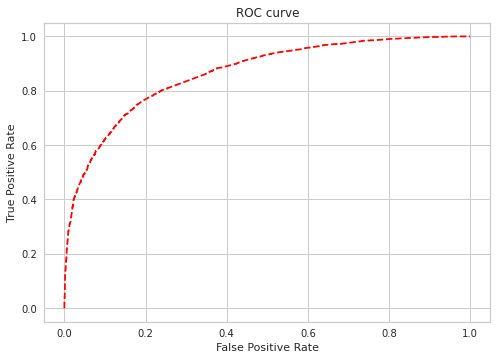

In [116]:
fpr, tpr, threshold = roc_curve(y_test,  y_pred_prob)
# auc = roc_auc_score(y_test, y_pred)

#create ROC curve
plt.plot(fpr,tpr,linestyle = '--' , color = 'red')
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

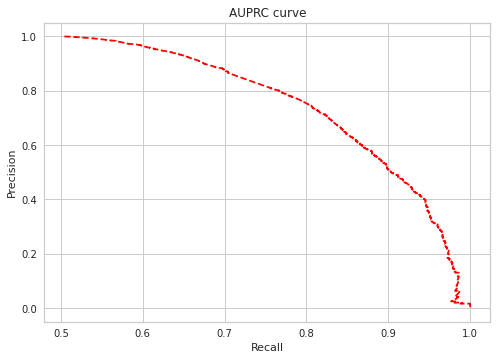

In [117]:
prec , recall, thresh = precision_recall_curve(y_test,y_pred_prob)
#create ROC curve
plt.plot(prec,recall,linestyle = '--' , color = 'red')
plt.title('AUPRC curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [118]:
# creating the tokenizer 
# tokenizer = tf.keras.preprocessing.text.Tokenizer()
# tokenizer.fit_on_texts(processed_data)

# encoding the data
# tokenized_data = tokenizer.texts_to_sequences(processed_data)

# padding the data for Neural Network
# max_length = max([len(s.split()) for s in processed_data])
# X = tf.keras.preprocessing.sequence.pad_sequences(tokenized_data, maxlen=max_length, padding='post')
# y = np.array(data.label)

### Compare the Results

In [119]:
'''
XGBoost:
Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.
By analogy, the Higher the AUC, the better the model is at distinguishing between given classes
ROC curve gives the trade-off between specificity and sensitivity
The ROC curve is closer to top left corner which is considered to be better 

Precision-Recall curve describes how good a model is at predicting the positive class.
The ROC curve is closer to top right corner which is considered to be better

KMeans:
KMeans is predicting unseen data with 0.64% accuracy. 
XGBoost is predicting well on unseen data comparing to KMeans.

K-means interprete the variance and distribution of each variable in a spherical shape. Means all the variables have the same variance. Now here probability for 2 clusters are same.
If any one of these condistion is violates in the training then k-means fails to identify classes.
I think this might be reason why K-means is performing bad over here.
Other reason might the preprocess and preparation of the data.

Linear SVC:
Linear SVC performs the best so far of all models trained.
It is predicting the unseen data with 88% accuracy which is very good.
I notice one difference between training accuracy and test accuracy of the model. Training accuracy is 94% while test accuracy is 88%. Which is unusual for ideal model.
Both accuracy should be somewhere around same for ideal model. Here model might be overfitting on the data. 
But regardless of that so far, Linear SVC is performing best of all 3 models.

I also used CNN model here to do the sentiment analysis on the dataset. To make the feature size same for all reviews, using padding concept. In this format the data is fitted on cnn models for
sentiment analysis. It was giving around same accuracy as K-means. SO to avoid the analysis more complex, removed it from the notebook. Added how the padding is done in above cell.
'''


'\nXGBoost:\nHigher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.\nBy analogy, the Higher the AUC, the better the model is at distinguishing between given classes\nROC curve gives the trade-off between specificity and sensitivity\nThe ROC curve is closer to top left corner which is considered to be better \n\nPrecision-Recall curve describes how good a model is at predicting the positive class.\nThe ROC curve is closer to top right corner which is considered to be better\n\nKMeans:\nKMeans is predicting unseen data with 0.64% accuracy. \nXGBoost is predicting well on unseen data comparing to KMeans.\n\nK-means interprete the variance and distribution of each variable in a spherical shape. Means all the variables have the same variance. Now here probability for 2 clusters are same.\nIf any one of these condistion is violates in the training then k-means fails to identify classes.\nI think this might be reason why K-means is performing bad over here.\n